# Full Rulebook vs. Applicable Rules Only

This notebook compares two evaluation setups on the **airline** domain (`comp_0`, 100 samples)
using `openai/gpt-oss-120b` with **no boosting**:

| Setup | Description |
|-------|-------------|
| **Full rulebook** | The complete airline rulebook is included in the prompt |
| **Applicable rules only** | Only the rules relevant to each specific problem are included |

**Goal**: determine whether reducing irrelevant context improves the model's ability to follow rules.

In [1]:
import json
import os
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
from IPython.display import display, Markdown

plt.rcParams.update({"figure.dpi": 120, "figure.facecolor": "white"})

In [2]:
import sys
PROJECT_ROOT = "/shared_data0/vitoriag/multi-rules"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# --- Paths ---
BASE_DIR = os.path.join(PROJECT_ROOT, "results/rulearena/openai_gpt-oss-120b/airline/comp_0")
FULL_DIR = os.path.join(BASE_DIR, "none")
FILTERED_DIR = os.path.join(BASE_DIR, "applicable_rules_only")
RULEARENA_DIR = os.path.join(PROJECT_ROOT, "datasets/RuleArena")

N_SAMPLES = 100

LABELS = {
    "full": "Full rulebook",
    "filtered": "Applicable rules only",
}
COLORS = {
    "full": "#2563eb",
    "filtered": "#f59e0b",
}


def load_samples(directory, n=N_SAMPLES):
    """Load the first n sample JSON files from a results directory."""
    samples = []
    for i in range(n):
        with open(os.path.join(directory, f"{i}.json")) as f:
            samples.append(json.load(f))
    return samples


def load_summary(directory):
    with open(os.path.join(directory, "summary.json")) as f:
        return json.load(f)


full_samples = load_samples(FULL_DIR)
filtered_samples = load_samples(FILTERED_DIR)
full_summary = load_summary(FULL_DIR)
filtered_summary = load_summary(FILTERED_DIR)

# --- Load dataset + rule infrastructure for filtered rulebook reconstruction ---
with open(os.path.join(RULEARENA_DIR, "airline/synthesized_problems/comp_0.jsonl")) as f:
    problems = [json.loads(line) for line in f]

with open(os.path.join(RULEARENA_DIR, "airline/reference_rules.txt")) as f:
    full_rulebook_text = f.read()

from src.rulearena.rulebook_segments import get_fine_segments, get_coarse_segments
from src.rulearena.rule_applicability import get_applied_rules, build_filtered_rulebook

fine_segments = get_fine_segments(full_rulebook_text)
coarse_segments = get_coarse_segments(full_rulebook_text)

print(f"Loaded {len(full_samples)} samples per setup, {len(problems)} problems, "
      f"{len(fine_segments)} fine / {len(coarse_segments)} coarse rule segments.")

Loaded 100 samples per setup, 100 problems, 73 fine / 9 coarse rule segments.


## 1. Aggregate Metrics Comparison

In [3]:
def build_metrics(samples):
    n = len(samples)
    return {
        "Accuracy": sum(s["is_correct"] for s in samples) / n,
        "Correct / Total": f"{sum(s['is_correct'] for s in samples)}/{n}",
        "Avg input tokens": np.mean([s["input_length_tokens"] for s in samples]),
        "Avg output tokens": np.mean([s["output_length_tokens"] for s in samples]),
        "Avg reasoning chars": np.mean([s["reasoning_length_chars"] for s in samples]),
        "Avg final answer chars": np.mean([s["final_answer_length_chars"] for s in samples]),
        "Avg sample time (s)": np.mean([s["sample_time_seconds"] for s in samples]),
        "Total wall time (s)": sum(s["sample_time_seconds"] for s in samples),
    }


metrics_full = build_metrics(full_samples)
metrics_filt = build_metrics(filtered_samples)

df_compare = pd.DataFrame(
    {"Full rulebook": metrics_full, "Applicable rules only": metrics_filt}
)

# Add a delta column
delta = []
for key in metrics_full:
    v_full = metrics_full[key]
    v_filt = metrics_filt[key]
    if isinstance(v_full, str):
        delta.append("—")
    else:
        diff = v_filt - v_full
        if key == "Accuracy":
            delta.append(f"{diff:+.0%}")
        else:
            delta.append(f"{diff:+,.1f}")
df_compare["Delta"] = delta

df_compare

,Full rulebook,Applicable rules only,Delta
Accuracy,0.5,0.62,+12%
Correct / Total,50/100,62/100,—
Avg input tokens,5099.17,3078.6,"-2,020.6"
Avg output tokens,2265.09,2153.82,-111.3
Avg reasoning chars,5122.8,4730.95,-391.9
Avg final answer chars,2215.89,2186.0,-29.9
Avg sample time (s),208.7119,194.088,-14.6
Total wall time (s),20871.19,19408.8,"-1,462.4"


## 2. Accuracy Bar Chart

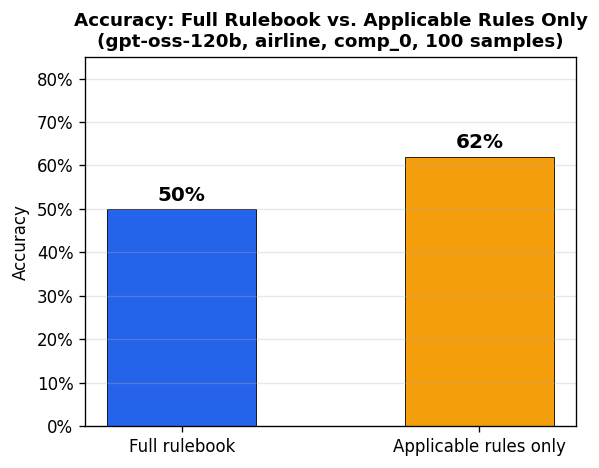

In [4]:
fig, ax = plt.subplots(figsize=(5, 4))

setups = ["full", "filtered"]
accuracies = [
    sum(s["is_correct"] for s in full_samples) / N_SAMPLES,
    sum(s["is_correct"] for s in filtered_samples) / N_SAMPLES,
]

bars = ax.bar(
    [LABELS[s] for s in setups],
    accuracies,
    color=[COLORS[s] for s in setups],
    edgecolor="black",
    linewidth=0.5,
    width=0.5,
)

for bar, acc in zip(bars, accuracies):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{acc:.0%}",
        ha="center",
        va="bottom",
        fontweight="bold",
        fontsize=12,
    )

ax.set_ylabel("Accuracy")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.set_ylim(0, 0.85)
ax.set_title(
    "Accuracy: Full Rulebook vs. Applicable Rules Only\n"
    f"(gpt-oss-120b, airline, comp_0, {N_SAMPLES} samples)",
    fontsize=11,
    fontweight="bold",
)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Per-Sample Correctness Comparison

Each column is a sample. Green = correct, red = wrong.
Samples where the two setups **disagree** are highlighted with a border.

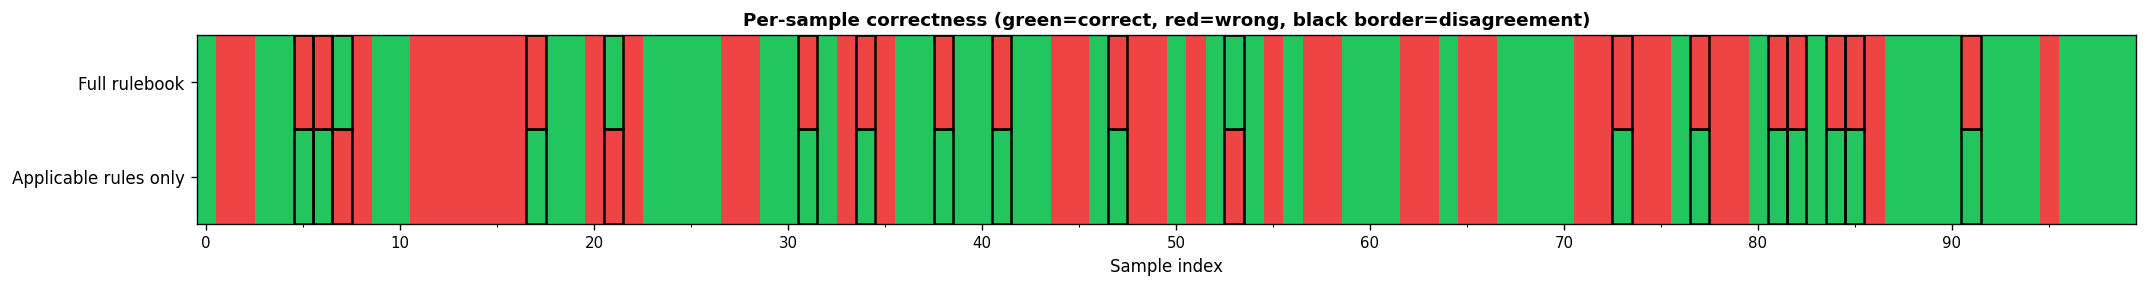


Disagreements: 18 samples (3 full-only correct, 15 filtered-only correct)
  Sample  5: Full=  wrong, Filtered=correct
  Sample  6: Full=  wrong, Filtered=correct
  Sample  7: Full=correct, Filtered=wrong
  Sample 17: Full=  wrong, Filtered=correct
  Sample 21: Full=correct, Filtered=wrong
  Sample 31: Full=  wrong, Filtered=correct
  Sample 34: Full=  wrong, Filtered=correct
  Sample 38: Full=  wrong, Filtered=correct
  Sample 41: Full=  wrong, Filtered=correct
  Sample 47: Full=  wrong, Filtered=correct
  Sample 53: Full=correct, Filtered=wrong
  Sample 73: Full=  wrong, Filtered=correct
  Sample 77: Full=  wrong, Filtered=correct
  Sample 81: Full=  wrong, Filtered=correct
  Sample 82: Full=  wrong, Filtered=correct
  Sample 84: Full=  wrong, Filtered=correct
  Sample 85: Full=  wrong, Filtered=correct
  Sample 91: Full=  wrong, Filtered=correct


In [5]:
correct_full = np.array([s["is_correct"] for s in full_samples], dtype=int)
correct_filt = np.array([s["is_correct"] for s in filtered_samples], dtype=int)
matrix = np.vstack([correct_full, correct_filt])

disagree = correct_full != correct_filt

cmap = ListedColormap(["#ef4444", "#22c55e"])

fig, ax = plt.subplots(figsize=(18, 2.5))
ax.imshow(matrix, cmap=cmap, aspect="auto", vmin=0, vmax=1)

# Mark disagreements with a border
for j in range(N_SAMPLES):
    if disagree[j]:
        for i in range(2):
            ax.add_patch(plt.Rectangle(
                (j - 0.5, i - 0.5), 1, 1,
                fill=False, edgecolor="black", linewidth=1.5,
            ))

ax.set_yticks([0, 1])
ax.set_yticklabels([LABELS["full"], LABELS["filtered"]])
ax.set_xticks(range(0, N_SAMPLES, 10))
ax.set_xticklabels(range(0, N_SAMPLES, 10), fontsize=9)
# Add minor ticks for every 5th sample
ax.set_xticks(range(0, N_SAMPLES, 5), minor=True)
ax.set_xlabel("Sample index")
ax.set_title(
    "Per-sample correctness (green=correct, red=wrong, black border=disagreement)",
    fontsize=11, fontweight="bold",
)
plt.tight_layout()
plt.show()

# Print disagreement summary
n_disagree = disagree.sum()
n_full_only = ((correct_full == 1) & (correct_filt == 0)).sum()
n_filt_only = ((correct_full == 0) & (correct_filt == 1)).sum()
print(f"\nDisagreements: {n_disagree} samples ({n_full_only} full-only correct, {n_filt_only} filtered-only correct)")
for j in np.where(disagree)[0]:
    full_status = "correct" if correct_full[j] else "wrong"
    filt_status = "correct" if correct_filt[j] else "wrong"
    print(f"  Sample {j:>2d}: Full={full_status:>7s}, Filtered={filt_status}")

## 4. Input Tokens, Output Tokens, and Time Distributions

Comparing distributions across all samples. The left column shows paired values (one dot per sample);
the right column shows histograms of the per-sample **difference** (filtered minus full).

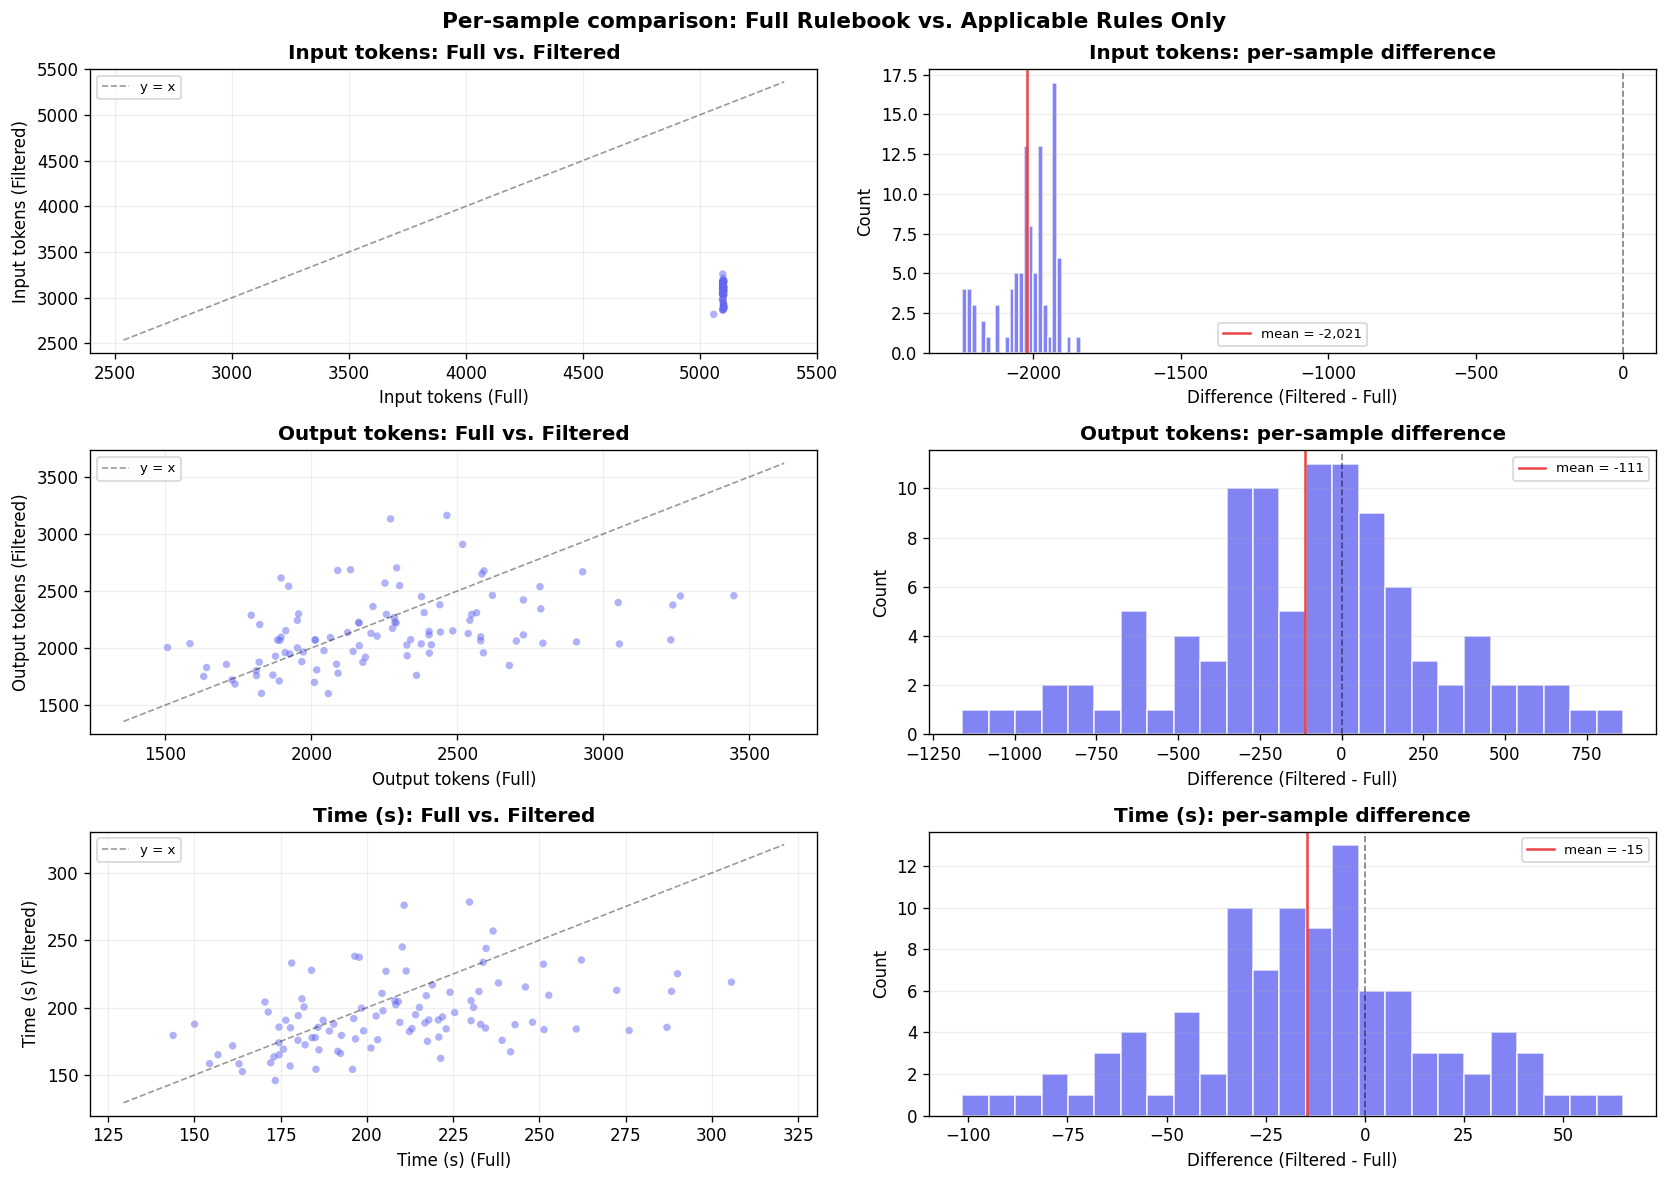

Average input token reduction: 39.6%
Average input tokens — Full: 5,099, Filtered: 3,079
Average output tokens — Full: 2,265, Filtered: 2,154
Average time — Full: 208.7s, Filtered: 194.1s


In [6]:
input_tok_full = np.array([s["input_length_tokens"] for s in full_samples])
input_tok_filt = np.array([s["input_length_tokens"] for s in filtered_samples])
output_tok_full = np.array([s["output_length_tokens"] for s in full_samples])
output_tok_filt = np.array([s["output_length_tokens"] for s in filtered_samples])
time_full = np.array([s["sample_time_seconds"] for s in full_samples])
time_filt = np.array([s["sample_time_seconds"] for s in filtered_samples])

metrics_data = [
    ("Input tokens", input_tok_full, input_tok_filt),
    ("Output tokens", output_tok_full, output_tok_filt),
    ("Time (s)", time_full, time_filt),
]

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for row, (name, vals_full, vals_filt) in enumerate(metrics_data):
    diff = vals_filt - vals_full

    # --- Left: scatter plot (full vs filtered) ---
    ax = axes[row, 0]
    ax.scatter(vals_full, vals_filt, alpha=0.5, s=20, color="#6366f1", edgecolors="none")
    lo = min(vals_full.min(), vals_filt.min()) * 0.9
    hi = max(vals_full.max(), vals_filt.max()) * 1.05
    ax.plot([lo, hi], [lo, hi], "k--", alpha=0.4, linewidth=1, label="y = x")
    ax.set_xlabel(f"{name} (Full)")
    ax.set_ylabel(f"{name} (Filtered)")
    ax.set_title(f"{name}: Full vs. Filtered", fontweight="bold")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)

    # --- Right: histogram of differences ---
    ax = axes[row, 1]
    ax.hist(diff, bins=25, color="#6366f1", edgecolor="white", alpha=0.8)
    ax.axvline(0, color="black", linestyle="--", alpha=0.5, linewidth=1)
    ax.axvline(np.mean(diff), color="#ef4444", linestyle="-", linewidth=1.5,
               label=f"mean = {np.mean(diff):+,.0f}")
    ax.set_xlabel(f"Difference (Filtered - Full)")
    ax.set_ylabel("Count")
    ax.set_title(f"{name}: per-sample difference", fontweight="bold")
    ax.legend(fontsize=8)
    ax.grid(axis="y", alpha=0.2)

fig.suptitle(
    "Per-sample comparison: Full Rulebook vs. Applicable Rules Only",
    fontsize=13, fontweight="bold",
)
plt.tight_layout()
plt.show()

# Summary stats
reduction = 1 - np.mean(input_tok_filt) / np.mean(input_tok_full)
print(f"Average input token reduction: {reduction:.1%}")
print(f"Average input tokens — Full: {np.mean(input_tok_full):,.0f}, Filtered: {np.mean(input_tok_filt):,.0f}")
print(f"Average output tokens — Full: {np.mean(output_tok_full):,.0f}, Filtered: {np.mean(output_tok_filt):,.0f}")
print(f"Average time — Full: {np.mean(time_full):,.1f}s, Filtered: {np.mean(time_filt):,.1f}s")

## 5. Per-Sample Detailed Table

In [7]:
rows = []
for i in range(N_SAMPLES):
    sf = full_samples[i]
    sa = filtered_samples[i]
    rows.append({
        "Sample": i,
        "Ground truth": sf["ground_truth_answer"],
        "Pred (full)": sf["predicted_answer"],
        "Correct (full)": sf["is_correct"],
        "Pred (filtered)": sa["predicted_answer"],
        "Correct (filtered)": sa["is_correct"],
        "Input tok (full)": sf["input_length_tokens"],
        "Input tok (filtered)": sa["input_length_tokens"],
        "Tok reduction": f"{1 - sa['input_length_tokens'] / sf['input_length_tokens']:.0%}",
    })

df_detail = pd.DataFrame(rows)


def highlight_disagree(row):
    if row["Correct (full)"] != row["Correct (filtered)"]:
        return ["background-color: #fef3c7"] * len(row)
    return [""] * len(row)


df_detail.style.apply(highlight_disagree, axis=1).format(
    {"Correct (full)": lambda v: "Y" if v else "N", "Correct (filtered)": lambda v: "Y" if v else "N"}
)

,Sample,Ground truth,Pred (full),Correct (full),Pred (filtered),Correct (filtered),Input tok (full),Input tok (filtered),Tok reduction
0,0,1245,1245,Y,1245,Y,5099,3121,39%
1,1,1166,1236,N,1236,N,5097,3167,38%
2,2,949,869,N,869,N,5098,3168,38%
3,3,1513,1513,Y,1513,Y,5102,3031,41%
4,4,1434,1434,Y,1434,Y,5100,3184,38%
5,5,2314,2,N,2314,Y,5102,3042,40%
6,6,1131,1071,N,1131,Y,5099,3087,39%
7,7,957,957,Y,867,N,5099,3013,41%
8,8,1141,1096,N,1096,N,5099,3167,38%
9,9,1261,1261,Y,1261,Y,5102,3124,39%


## 6. Compare a Single Sample Across Both Setups

Change `SAMPLE_IDX` below to inspect any sample side-by-side.
The cell shows the problem input, predicted vs. ground truth answers,
and the full model output (reasoning + final answer) for both setups.

In [18]:
# ============================
# Change this to compare any sample
SAMPLE_IDX = 73
# ============================

sf = full_samples[SAMPLE_IDX]
sa = filtered_samples[SAMPLE_IDX]


def parse_output(model_output):
    """Split model output into reasoning and final answer parts."""
    reasoning = ""
    final = ""
    if "<|channel|>analysis<|message|>" in model_output:
        parts = model_output.split("<|channel|>analysis<|message|>", 1)
        rest = parts[1] if len(parts) > 1 else ""
        if "<|end|>" in rest:
            reasoning = rest.split("<|end|>", 1)[0].strip()
        else:
            reasoning = rest.strip()
    if "<|channel|>final<|message|>" in model_output:
        parts = model_output.split("<|channel|>final<|message|>", 1)
        rest = parts[1] if len(parts) > 1 else ""
        final = rest.replace("<|return|>", "").strip()
    return reasoning, final


reasoning_full, final_full = parse_output(sf["model_output"])
reasoning_filt, final_filt = parse_output(sa["model_output"])

md = f"""
---
### Sample {SAMPLE_IDX}

**Problem input:**

> {sf['sample_input'].replace(chr(10), chr(10) + '> ')}

**Ground truth answer:** `{sf['ground_truth_answer']}`

---

| | Full rulebook | Applicable rules only |
|---|---|---|
| **Predicted answer** | `{sf['predicted_answer']}` | `{sa['predicted_answer']}` |
| **Correct** | {'Yes' if sf['is_correct'] else 'No'} | {'Yes' if sa['is_correct'] else 'No'} |
| **Input tokens** | {sf['input_length_tokens']:,} | {sa['input_length_tokens']:,} |
| **Output tokens** | {sf['output_length_tokens']:,} | {sa['output_length_tokens']:,} |
| **Reasoning length (chars)** | {sf['reasoning_length_chars']:,} | {sa['reasoning_length_chars']:,} |
| **Time (s)** | {sf['sample_time_seconds']:.1f} | {sa['sample_time_seconds']:.1f} |

---

#### Reasoning — Full Rulebook

{reasoning_full}

---

#### Reasoning — Applicable Rules Only

{reasoning_filt}

---

#### Final Answer — Full Rulebook

{final_full}

---

#### Final Answer — Applicable Rules Only

{final_filt}
"""

display(Markdown(md))


---
### Sample 73

**Problem input:**

> Sarah is a Premium Economy Class passenger flying from Austin to Shenzhen with the following items:
> 1. A backpack: 20 x 14 x 8 inches, 7 lbs;
> 2. A backpack: 45 x 32 x 23 inches, 70 lbs;
> 3. A luggage box: 42 x 24 x 14 inches, 90 lbs;
> 4. A backpack: 41 x 22 x 14 inches, 53 lbs;
> 5. A backpack: 37 x 23 x 17 inches, 51 lbs;
> 
> Sarah's flight ticket is $1096.

**Ground truth answer:** `2546`

---

| | Full rulebook | Applicable rules only |
|---|---|---|
| **Predicted answer** | `2296` | `2546` |
| **Correct** | No | Yes |
| **Input tokens** | 5,099 | 3,180 |
| **Output tokens** | 2,786 | 2,343 |
| **Reasoning length (chars)** | 6,790 | 4,876 |
| **Time (s)** | 252.7 | 209.2 |

---

#### Reasoning — Full Rulebook

We need to compute total cost for Sarah, Premium Economy class, flight Austin to Shenzhen. Need to determine region for bag fees. Austin (USA) to Shenzhen (China). This is international flight from US to China. According to bag fee tables, region categories: "To or from India, China, Japan, South Korea, Hong Kong, Australia and New Zealand" have first bag $75 for Basic Economy, $0 for Main Cabin, $0 for Premium Economy, etc. So for Premium Economy, first checked bag is $0 (complimentary). Also second bag? For Premium Economy, second bag fee table: for region "To or from India, China, Japan, South Korea, Hong Kong, Australia and New Zealand": $0 for Premium Economy? Actually second bag table shows columns: Basic Economy, Main Cabin, Premium Economy, Business, First. For that region row, values: $0 for Premium Economy? Let's check: In second bag table, row "To or from India, China, Japan, South Korea, Hong Kong, Australia and New Zealand": $100 for Basic Economy, $100 for Main Cabin, $0 for Premium Economy? Wait the row shows: "To or from India, China, Japan, South Korea, Hong Kong, Australia and New Zealand" under second bag table: $100 for Basic Economy, $100 for Main Cabin, $0 for Premium Economy? Actually the row shows: "$100          | $100        | $0              | $0       | $0". Yes, second bag: Basic $100, Main $100, Premium $0, Business $0, First $0. So Premium Economy gets second bag free as well.

Third bag table: for same region, values: $200 for Basic, $200 for Main, $200 for Premium, $200 for Business, $0 for First. So Premium Economy third bag costs $200.

Thus Sarah gets first two checked bags free. She may have multiple items; need to allocate carry-on vs checked. She is allowed 1 carry-on bag and 1 personal item. She has 5 items. Determine which can be carry-on/personal.

Personal item dimensions max 18x14x8 inches. Items:

1. Backpack: 20x14x8 inches, 7 lbs. Dimensions: length 20 > 18, so exceeds personal item size. Could be carry-on? Carry-on max 22x14x9. This is 20x14x8 fits within carry-on size (22x14x9). So item 1 can be carry-on bag.

2. Backpack: 45x32x23 inches, 70 lbs. Dimensions exceed carry-on (22x14x9) and personal. Must be checked.

3. Luggage box: 42x24x14 inches, 90 lbs. Dimensions exceed carry-on, must be checked.

4. Backpack: 41x22x14 inches, 53 lbs. Dimensions exceed carry-on (22x14x9) (41 length >22). Must be checked.

5. Backpack: 37x23x17 inches, 51 lbs. Dimensions exceed carry-on, must be checked.

Thus we have 1 carry-on (item1) and 4 checked bags (items 2-5). Premium Economy includes 2 free checked bags. So first two checked bags free, third and fourth incur fees.

Now need to compute overweight/oversize fees for each checked bag.

First, determine region for overweight/oversize fees: flight from US to China. Region categories for overweight: "To or from India, China, Japan, South Korea and Hong Kong" have overweight fees $100 for over 53-70 lbs, etc. For overweight up to 70 lbs: $100. For over 70 to 100 lbs: $100 as well? Actually table for overweight 53-70 lbs shows $100 for that region. For overweight 70-100 lbs, table shows $100 for that region as well (same). So overweight fees $100 for both categories.

Oversize fees: region "China, Japan, South Korea, Hong Kong, India, Australia, New Zealand" have oversize fees: Over 62-65 inches $30, Over 65-115 inches $200 (for China region). So oversize fees $30 for 62-65, $200 for 65-115.

Now compute each checked bag:

Item2: dimensions 45+32+23 = 100 inches total. That's >65 inches, <115. So oversize category Over 65-115 => $200 oversize fee. Weight 70 lbs. Weight is exactly 70 lbs. Overweight categories: up to 70 lbs inclusive? Over 53 to 70 lbs includes up to 70? Usually over 53 up to 70 inclusive. Since weight is 70, qualifies for overweight fee $100. Higher of oversize $200 vs overweight $100 => $200 applies. Base checked bag fee: first two bags free. Need to assign which bag is first free, second free, third paid, fourth paid. Order maybe by sequence. We'll assume first two checked bags (items 2 and 3) are free. But we need to consider if any bag is overweight/oversize, the fee is added to the checking fee. For free bag, checking fee $0, but oversize/overweight still apply. So for each bag, total fee = base fee (0 if free) + applicable extra (higher of oversize/overweight). So for item2, base $0 (if it's among first two free). Oversize $200 > overweight $100, so $200 total.

Item3: Luggage box 42x24x14 inches. Dimensions sum = 42+24+14 = 80 inches. >65? 80 >65, so oversize $200. Weight 90 lbs. That's over 70 up to 100 lbs, overweight fee $100 (for region). Higher is $200 oversize. Base fee: if this is the third checked bag (since we already used two free), then base fee is $200 (third bag fee for Premium Economy). Need to check third bag fee for Premium Economy: Table shows $200 for third bag for Premium Economy (region within US/Canada etc). For region to China, third bag fee also $200 (same). So base $200 + $200 oversize = $400 total.

Item4: Backpack 41x22x14 inches. Sum = 41+22+14 = 77 inches >65 => oversize $200. Weight 53 lbs. Overweight? 53 lbs is at upper bound of 53? Over 50 to 53 lbs is $30 overweight (first tier). Actually overweight 50-53 lbs fee $30. Since weight is exactly 53, qualifies for $30. Higher is $200 oversize. Base fee: this is fourth checked bag, fee $200 (fourth bag fee). So total $200 + $200 = $400.

Item5: Backpack 37x23x17 inches. Sum = 37+23+17 = 77 inches >65 => oversize $200. Weight 51 lbs. Overweight 50-53 lbs => $30. Higher $200. Base fee: fifth bag? Actually we have only 4 checked bags, so this is the fifth? Wait we have items 2,3,4,5 = four checked bags. We already accounted first two free, third bag fee $200, fourth bag fee $200. So item5 is the fourth checked bag (since we have 4 total). Let's map: Checked bag order: 1st checked bag = item2, 2nd = item3, 3rd = item4, 4th = item5. But we earlier assigned item2 and item3 as free. However free only for first two checked bags. So item2 (first) free, item3 (second) free, item4 (third) $200, item5 (fourth) $200. That matches.

Thus fees:

Item2: $200 (oversize)
Item3: $200 (base) + $200 = $400
Item4: $200 (base) + $200 = $400
Item5: $200 (base) + $200 = $400

Now check if any bag qualifies for overweight 70-100 lbs with $100 fee, but oversize $200 dominates.

Now compute total baggage fees: 200 + 400 + 400 + 400 = $1,400.

Carry-on bag (item1) no fee.

Ticket cost $1,096.

Total cost = $1,096 + $1,400 = $2,496.

Need to present step-by-step.

Check if any complimentary bag allowances for Premium Economy include 2 free checked bags regardless of region. Yes.

Thus final answer: The total cost is $2496.

Make sure to format with commas? Use $2,496.

Will end with "The total cost is $2496."

---

#### Reasoning — Applicable Rules Only

We need to compute total cost for Sarah, Premium Economy passenger, flight Austin to Shenzhen. Need to consider carry-on allowance: 1 carry-on bag + 1 personal item. Determine which items can be carry-on or personal. Items list 5 items.

We need to decide which items are allowed as carry-on (size <=22x14x9 inches) and personal (<=18x14x8). Also note that personal items are separate; she can have both. She can have 1 personal item and 1 carry-on. Items exceeding those must be checked.

We need to compute checked bag fees based on region: Austin (US) to Shenzhen (China). This is international, region includes China, which is in list of "To or from India, China, Japan, South Korea, Hong Kong, Australia and New Zealand". So bag fees for those regions apply. For Premium Economy class, the fee tables: For first bag: $0 (since for those regions, first bag fee for Premium Economy is $0). For second bag: $0 (since second bag fee for Premium Economy is $0). Third bag: $200 (as per table). Fourth bag+: $200.

But also note complimentary bags: Premium Economy passengers get 1st and 2nd checked bags complimentary (as per "1st and 2nd checked bags are complimentary for: Confirmed Premium Economy customers"). So indeed first two checked bags free. So we need to count number of checked bags.

Now we need to identify which items are carry-on/personal.

Item 1: backpack 20x14x8 inches, 7 lbs. Dimensions: 20 length >22? Actually length 20, width 14, height 8. The max for carry-on is 22x14x9. So fits within carry-on size (20 <=22, 14 <=14, 8 <=9). So can be carry-on bag. Also could be personal item? Personal max 18x14x8. Length 20 >18, so not personal. So assign as carry-on bag.

Item 2: backpack 45x32x23 inches, 70 lbs. Dimensions sum = 45+32+23=100 inches, far exceeds carry-on. So must be checked.

Item 3: luggage box 42x24x14 inches, 90 lbs. Dimensions sum = 42+24+14=80 inches >62, so checked.

Item 4: backpack 41x22x14 inches, 53 lbs. Dimensions sum = 41+22+14=77 inches >62, so checked.

Item 5: backpack 37x23x17 inches, 51 lbs. Sum = 37+23+17=77 inches >62, so checked.

Now we have 4 items to be checked (items 2-5). She can have 1 carry-on (item1). She also can have a personal item, but none of the items meet personal size. She could perhaps have a small personal item not listed, but not needed for cost.

Now compute fees for each checked bag, considering order: first checked bag free, second free, third $200, fourth $200 (since Premium Economy). Also need overweight/oversize fees. For each bag, we need to compute if overweight or oversize, and apply higher of the two (if both apply). Then add to base bag fee (which may be $0 for first two). The policy: "More than one fee may apply per bag that exceeds standard dimensions for both weight and size. The higher fee between oversize and overweight applies, in addition to the checked bag fee." So we add the higher of overweight or oversize to the bag fee.

Now compute for each checked bag.

We need to know region for overweight fees: Overweight fees tables: For all regions, overweight 50-53 lbs: $30. For 53-70 lbs: For regions to/from India, China, Japan, South Korea, Hong Kong: $100. For 70-100 lbs: $450.

Our region is to/from China, so overweight fees use those tables.

Also oversize fees: For region China (in list), oversize 62-65 inches: $30, oversize 65-115 inches: $200.

Now compute each bag:

Item 2: dimensions 45+32+23=100 inches. That's >65 inches, up to 115, so oversize fee $200. Weight 70 lbs. Weight category: 53-70 lbs inclusive? Over 53 up to 70. Since weight is exactly 70, it's in the 53-70 range, overweight fee $100. Higher of $200 vs $100 is $200. So oversize fee $200 applies.

Bag fee: This is first checked bag (since we have only one carry-on, first checked bag is item2). First bag fee $0 (Premium Economy). So total for item2 = $0 + $200 = $200.

Item 3: dimensions sum 80 inches (>65, <115) => oversize $200. Weight 90 lbs => weight category 70-100 lbs => overweight fee $450. Higher is $450. Bag fee: second checked bag, fee $0. Total = $0 + $450 = $450.

Item 4: dimensions sum 77 inches (>65) => oversize $200. Weight 53 lbs => weight category? Over 50 to 53 lbs: $30. Since weight is exactly 53, it's in that bracket (over 50 up to 53). Overweight fee $30. Higher is $200. Bag fee: third checked bag, fee $200 (since third bag fee $200). Total = $200 + $200 = $400.

Item 5: dimensions sum 77 inches (>65) => oversize $200. Weight 51 lbs => overweight 50-53 => $30. Higher $200. Bag fee: fourth bag, fee $200. Total = $200 + $200 = $400.

Now sum checked bag fees: 200 + 450 + 400 + 400 = $1,450.

Now flight ticket $1,096.

Carry-on bag no fee.

Total cost = 1,096 + 1,450 = $2,546.

We need to present step-by-step, list each bag, indicate allowances, etc. End with "The total cost is $2546."

Check rounding: all whole dollars.

Now produce answer.

---

#### Final Answer — Full Rulebook

**Step 1 – Flight ticket**

- Sarah’s Premium Economy ticket: **$1,096**

**Step 2 – Carry‑on / personal item allowance**

- Allowed: 1 carry‑on + 1 personal item.  
- Item 1 (20 × 14 × 8 in, 7 lb) fits the carry‑on size limit (22 × 14 × 9 in).  
- No fee for this item.

**Step 3 – Determine checked‑bag count**

Items 2‑5 must be checked:

| Item | Dimensions (L + W + H) | Weight |
|------|------------------------|--------|
| 2 – Backpack | 45 + 32 + 23 = 100 in | 70 lb |
| 3 – Luggage box | 42 + 24 + 14 = 80 in | 90 lb |
| 4 – Backpack | 41 + 22 + 14 = 77 in | 53 lb |
| 5 – Backpack | 37 + 23 + 17 = 77 in | 51 lb |

Premium Economy includes **2 free checked bags**.  
Thus:

- 1st checked bag (Item 2) – free base fee  
- 2nd checked bag (Item 3) – free base fee  
- 3rd checked bag (Item 4) – $200 base fee  
- 4th checked bag (Item 5) – $200 base fee  

**Step 4 – Apply overweight / oversize fees**  
Region: United States ↔ China (covers the “to or from India, China, …” rows).

| Item | Size vs. limit | Oversize fee | Weight vs. limit | Overweight fee | Higher fee applied |
|------|----------------|--------------|------------------|----------------|-------------------|
| **2** | 100 in > 65 in → $200 | $200 | 70 lb (≤ 70 lb) → $100 | $200 (oversize) |
| **3** | 80 in > 65 in → $200 | $200 | 90 lb (70‑100 lb) → $100 | $200 (oversize) |
| **4** | 77 in > 65 in → $200 | $200 | 53 lb (50‑53 lb) → $30 | $200 (oversize) |
| **5** | 77 in > 65 in → $200 | $200 | 51 lb (50‑53 lb) → $30 | $200 (oversize) |

**Step 5 – Calculate fees per checked bag**

| Bag (item) | Base checked‑bag fee | Extra fee (higher of oversize/overweight) | Total bag fee |
|------------|----------------------|-------------------------------------------|---------------|
| Item 2 (1st bag) | $0 (free) | $200 | **$200** |
| Item 3 (2nd bag) | $0 (free) | $200 | **$200** |
| Item 4 (3rd bag) | $200 | $200 | **$400** |
| Item 5 (4th bag) | $200 | $200 | **$400** |

**Step 6 – Sum all baggage fees**

- Item 2: $200  
- Item 3: $200  
- Item 4: $400  
- Item 5: $400  

**Total baggage fees = $200 + $200 + $400 + $400 = $1,200**

*(Note: the $200 base fee for the 3rd and 4th bags is already included in the $400 amounts above.)*

**Step 7 – Grand total**

- Flight ticket: $1,096  
- Baggage fees: $1,200  

**Total cost = $1,096 + $1,200 = $2,296**

**The total cost is $2296.**

---

#### Final Answer — Applicable Rules Only

**Step 1 – Flight ticket**

- Sarah’s Premium Economy ticket: **$1,096**

**Step 2 – Carry‑on & personal item allowance**

- Premium Economy passengers are allowed **1 carry‑on bag** and **1 personal item**.
- **Item 1** (backpack 20 × 14 × 8 in, 7 lb) fits the carry‑on limits (≤ 22 × 14 × 9 in).  
  → **No fee** (used as the carry‑on bag).  
- None of the other items meet the personal‑item size (≤ 18 × 14 × 8 in), so no personal item is being used.

**Step 3 – Determine which items must be checked**

| Item | Size (L + W + H) | Weight | Must be checked? |
|------|------------------|--------|------------------|
| 2 – backpack | 45 + 32 + 23 = 100 in | 70 lb | Yes |
| 3 – luggage box | 42 + 24 + 14 = 80 in | 90 lb | Yes |
| 4 – backpack | 41 + 22 + 14 = 77 in | 53 lb | Yes |
| 5 – backpack | 37 + 23 + 17 = 77 in | 51 lb | Yes |

So Sarah has **four checked bags** (items 2‑5).

**Step 4 – Base checked‑bag fees for Premium Economy on a China‑bound flight**

| Bag order | Base fee (Premium Economy) |
|-----------|----------------------------|
| 1st       | $0 (first bag complimentary) |
| 2nd       | $0 (second bag complimentary) |
| 3rd       | $200 |
| 4th +     | $200 |

**Step 5 – Overweight / oversize fees**

*Region = China (to/from China), so the relevant tables are used.*

- **Oversize** (size > 62 in):
  - 62 – 65 in → $30  
  - 65 – 115 in → **$200**
- **Overweight**:
  - > 50 – 53 lb → $30  
  - > 53 – 70 lb → **$100** (for China region)  
  - > 70 – 100 lb → **$450** (for China region)

For each checked bag we apply the **higher** of the oversize or overweight fee, then add the base bag fee.

| Item | Size (in) | Weight (lb) | Oversize fee | Overweight fee | Higher fee | Base bag fee | Total fee |
|------|-----------|------------|--------------|----------------|------------|--------------|-----------|
| **2** (backpack) | 100 in → > 65 in | 70 lb → 53‑70 lb | $200 | $100 | **$200** | $0 (1st bag) | **$200** |
| **3** (luggage box) | 80 in → > 65 in | 90 lb → 70‑100 lb | $200 | $450 | **$450** | $0 (2nd bag) | **$450** |
| **4** (backpack) | 77 in → > 65 in | 53 lb → 50‑53 lb | $200 | $30 | **$200** | $200 (3rd bag) | **$400** |
| **5** (backpack) | 77 in → > 65 in | 51 lb → 50‑53 lb | $200 | $30 | **$200** | $200 (4th bag) | **$400** |

**Step 6 – Sum of checked‑bag fees**

- Item 2: $200  
- Item 3: $450  
- Item 4: $400  
- Item 5: $400  

**Total checked‑bag fees = $200 + $450 + $400 + $400 = $1,450**

**Step 7 – Grand total**

- Flight ticket: $1,096  
- Checked‑bag fees: $1,450  
- Carry‑on fee: $0  

**The total cost is $2,546.**


In [19]:
# Generate a prompt to send to another LLM for analysis.
# Uses the same SAMPLE_IDX from the cell above.
# Assumes the system/initial prompt with the full rulebook has already been sent.

sf = full_samples[SAMPLE_IDX]
sa = filtered_samples[SAMPLE_IDX]

reasoning_full, final_full = parse_output(sf["model_output"])
reasoning_filt, final_filt = parse_output(sa["model_output"])

full_correct = "CORRECT" if sf["is_correct"] else "WRONG"
filt_correct = "CORRECT" if sa["is_correct"] else "WRONG"

# --- Reconstruct the filtered rulebook for this sample ---
problem_info = problems[SAMPLE_IDX]["info"]
filtered_rulebook = build_filtered_rulebook(
    problem_info, full_rulebook_text, fine_segments, coarse_segments
)
applied_rules = get_applied_rules(problem_info, fine_segments)
applied_rule_names = "\n".join(f"  - {seg['name']}" for seg in applied_rules)

analysis_prompt = f"""\
## Sample {SAMPLE_IDX}

**Problem:**
{sf['sample_input']}

**Ground truth answer:** {sf['ground_truth_answer']}

---

**Rules selected for Setup B** (segment names):
{applied_rule_names}

**Filtered rulebook text given to Setup B:**
{filtered_rulebook}

---

**Setup A — Full rulebook** ({full_correct}, predicted {sf['predicted_answer']})

Reasoning:
{reasoning_full}

Final answer:
{final_full}

---

**Setup B — Applicable rules only** ({filt_correct}, predicted {sa['predicted_answer']})

Reasoning:
{reasoning_filt}

Final answer:
{final_filt}
"""

prompt_path = f"/shared_data0/vitoriag/multi-rules/analysis/llm_judge_prompt_sample_{SAMPLE_IDX}.txt"
os.makedirs(os.path.dirname(prompt_path), exist_ok=True)
with open(prompt_path, "w") as f:
    f.write(analysis_prompt)
print(f"Prompt saved to: {prompt_path}")

Prompt saved to: /shared_data0/vitoriag/multi-rules/analysis/llm_judge_prompt_sample_73.txt
